In this example, we are solving the robust scenario optimization problem

$$
\begin{aligned}
    \min_{x, u} \quad & \frac{1}{N_s} \sum_{j=1}^{N_s} \left( \sum_{i=0}^{N-1} \ell_i(x_i^j,u_i^j) + \ell_N(x_N^j) \right) \\
    \text {s.t.}\quad & x_0^j = \bar{x}_0, u_0^1 = u_0^j \\
    & x^j_{i+1} = A^j x_i^j + B^j u_i^j, \\
    & -4 \cdot \mathbf{1}_{n_x} \leq x^j_i \leq 4 \cdot \mathbf{1}_{n_x}, \\
    & -0.5 \cdot \mathbf{1}_{n_u} \leq u^j_i \leq 0.5 \cdot \mathbf{1}_{n_u},
\end{aligned}
$$

for a system of oscillating masses. It's an extension of the classic MPC problem. Essentially, we are rolling out $N_s$ scenarios, where each scenario $j$ has different dynamics $A^j$ and $B^j$. The first state $x_0$ is fixed and the first input $u_0$ is the same as for all scenarios. This allows us to be robust in respect to all scenario roll-outs and achieve optimal performance in the expectation.

We'll see how to formulate it using Python and how PIQP's `sparse_multistage` KKT solver backend can be used to achieve a considerable speedup compared to the standard sparse KKT solver backend.

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.signal import cont2discrete
from scipy.linalg import solve_discrete_are

import piqp

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

np.random.seed(42)

## Model

We start by defining the system dynamics. We are considering the system of oscillating masses as shown below:

![oscillating masses](oscillating_masses.svg)

The system consists out of $M$ masses, where each mass is described by its position $p_i$ and its velocity $v_i$. We then describe the state of the whole system as $x=[p_1,\dots,p_M,v_1,\dots,v_M]^\top$. The last $M-1$ masses can be controlled through a input force acting on them which we collect in the input vector $u$. The following class builds the system dynamics in continuous time and discretizes it with a time step of 0.5s.

In [2]:
class ChainMassSystem:
    def __init__(self, M, m=1.0, c=0.1, k=1.0):
        self.M = M

        # System parameters
        self.m = m # mass
        self.c = c # damping
        self.k = k # spring constant

        self.nx_max = 4.0
        self.nu_max = 0.5

        # System dimensions
        self.nx = 2 * M
        self.nu = M - 1
        
        # Initialize system matrices
        self._setup_system()
        
    def _setup_system(self):
        # Build continuous system matrices
        L = np.eye(self.M, k=-1)
        self.A = np.block([
            [np.zeros((self.M, self.M)),
             np.eye(self.M)],
            [(-2 * self.k * np.eye(self.M) + self.k * L + self.k * L.T) / self.m,
             (-2 * self.c * np.eye(self.M)) / self.m]
        ])
        self.B = np.block([[np.zeros((2 * self.M - self.nu, self.nu))],
                           [np.eye(self.nu)]])
        self.C = np.eye(self.nx)
        self.D = np.zeros((self.nx, self.nu))
        
        # Discretize system
        dt = 0.5
        d_sys = cont2discrete((self.A, self.B, self.C, self.D), dt, method='zoh')
        self.Ad = d_sys[0]
        self.Bd = d_sys[1]
        
        # Cost matrices
        self.Q = 1e3 * np.eye(self.nx)
        self.R = 1e-1 * np.eye(self.nu)
        self.QN = solve_discrete_are(self.Ad, self.Bd, self.Q, self.R)

We start by setting up some parameters and sample $N_s$ systems, where we the spring constant is uniformly sampled from $[1.0,2.0]$.

In [3]:
M = 3  # number of masses
N = 5  # MPC horizon
Ns = 3 # number of scenarios

def setup_systems():
    global systems, nx, nu

    # sample Ns spring constants between 1.0 and 2.0
    ks = np.linspace(1.0, 2.0, Ns)
    # generate Ns systems
    systems = [ChainMassSystem(M, k=k) for k in ks]
    
    nx = systems[0].nx
    nu = systems[0].nu

setup_systems()

Let's sample the initial state uniformly from $[-1.0,1.0]$, i.e., the positions and velocities of the masses are in this range.

In [4]:
def random_x0():
    return np.random.uniform(-1.0, 1.0, nx)

x0 = random_x0()

We will transcribe the problem into a general sparse QP formulation expected by PIQP:

$$
\begin{aligned}
\min_{x} \quad & \frac{1}{2} x^\top P x + c^\top x \\
\text {s.t.}\quad & Ax=b, \\
& h_l \leq Gx \leq h_u, \\
& x_l \leq x \leq x_u,
\end{aligned}
$$

While the generic `sparse_ldlt` solver backend can accept any sparse problem formulation, we need to make sure that ordering of the variables is correct for the `sparse_multistage` backend. Since $x_0$ and $u_0$ are coupled with all scenarios, we put them at the end, i.e. $g = (x_0,u_0)$. Hence, we define the primal variable as $x=(x_1^1,u_1^1,\dots,x_{N}^1,x_1^2,u_1^2,\dots,x_{N}^{N_s}, x_0, u_0)$.

In [5]:
def setup_problem():
    global n, p, P, c, A, b, x_l, x_u

    # number of decision variables
    n = nx + nu + Ns * ((N - 1) * (nx + nu) + nx)
    # number of equality constraints
    p = Ns * N * nx

    # empty problem data matrices
    P = sp.csc_matrix((n, n))
    c = np.zeros(n)
    A = sp.csc_matrix((p, n))
    b = np.zeros(p)
    x_l = np.zeros(n)
    x_u = np.zeros(n)

setup_problem()

Let's add the constraints for the initial state $x_0$ and the bounds for $u_0$. Note that they are located at the end of the primal decision variable $x$.

In [6]:
def setup_x0_u0():
    # initial state x0
    x_l[-(nx+nu):-nu] = x0
    x_u[-(nx+nu):-nu] = x0
    # bounds for u0
    x_l[-nu:] = -systems[0].nu_max
    x_u[-nu:] = systems[0].nu_max

setup_x0_u0()

Let's fill the $P$ matrix for the cost. We will use a standard quadratic cost which regulates the state of the system to zero, i.e.

$$
\ell_i(x_i,u_i) = x_i^\top Q x_i + u_i^\top R u_i, \quad \ell_N(x_N) = x_N^\top Q_N x_N,
$$

where $Q_N$ is the solution of the discrete Riccati equation.

The structure of the cost matrix P will have the following structure:

$$
P = \frac{1}{N_s} \begin{bmatrix}
Q &   &   &   &        &     &        &       &       \\
  & R &   &   &        &     &        &       &       \\
  &   & Q &   &        &     &        &       &       \\
  &   &   & R &        &     &        &       &       \\
  &   &   &   & \ddots &     &        &       &       \\
  &   &   &   &        & Q_N &        &       &       \\
  &   &   &   &        &     & \ddots &       &       \\
  &   &   &   &        &     &        & N_s Q &       \\
  &   &   &   &        &     &        &       & N_s R \\
\end{bmatrix}
$$

In [7]:
def setup_cost():
  # initial state
  P[-(nx+nu):-nu, -(nx+nu):-nu] = systems[0].Q
  P[-nu:, -nu:] = systems[0].R

  for s in range(Ns):
      offset = s * ((N - 1) * (nx + nu) + nx) - (nx + nu)
      for i in range(1, N):
          # state cost
          P[offset+i*(nx+nu):offset+i*(nx+nu)+nx, 
            offset+i*(nx+nu):offset+i*(nx+nu)+nx] = systems[s].Q / Ns
          # input cost
          P[offset+i*(nx+nu)+nx:offset+i*(nx+nu)+nx+nu, 
            offset+i*(nx+nu)+nx:offset+i*(nx+nu)+nx+nu] = systems[s].R / Ns
          
      # terminal cost
      P[offset+N*(nx+nu):offset+N*(nx+nu)+nx, 
        offset+N*(nx+nu):offset+N*(nx+nu)+nx] = systems[s].QN / Ns
      
setup_cost()

Looking at the sparsity pattern confirms that we populated $P$ correctly.

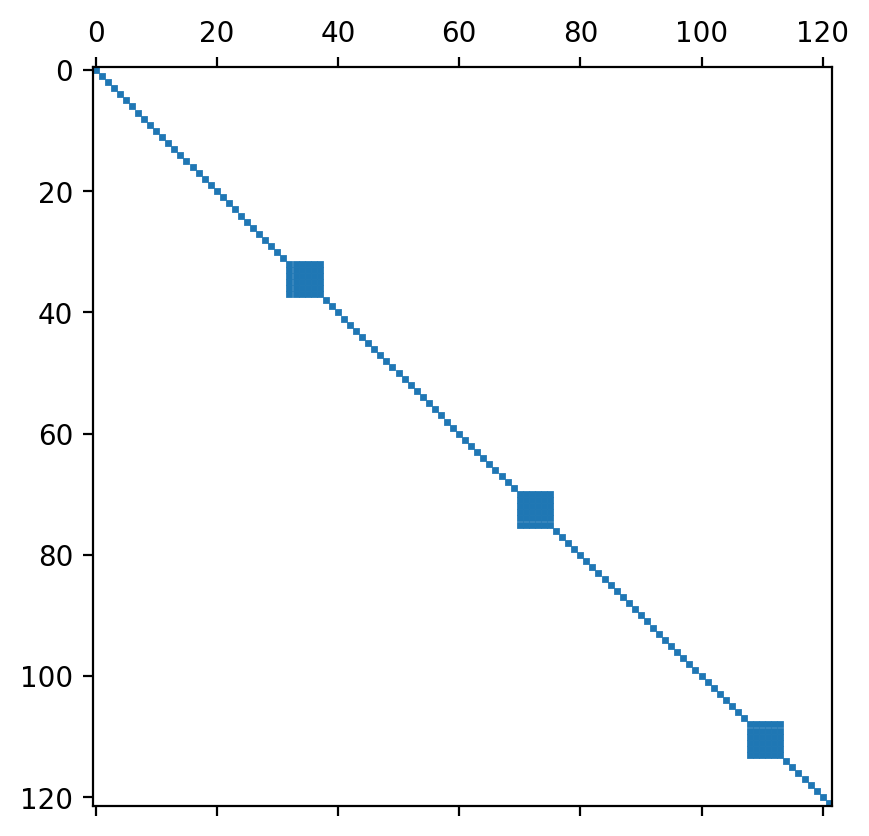

In [8]:
plt.spy(P, markersize=1.75)
plt.show()

While the order of the dynamics constraints don't matter, we model them in chronological order to be consistent with the original problem formulation. This means that our $A$ matrix should look something like:

$$
A = \begin{bmatrix}
-I  &     &     &     &        &     &     &     &     &        &        & A^1    & B^1    \\
A^1 & B^1 & -I  &     &        &     &     &     &     &        &        &        &        \\
    &     & A^1 & B^1 & -I     &     &     &     &     &        &        &        &        \\
    &     &     &     & \ddots &     &     &     &     &        & \cdots &        &        \\
    &     &     &     &        & -I  &     &     &     &        &        & A^2    & B^2    \\
    &     &     &     &        & A^2 & B^2 & -I  &     &        &        &        &        \\
    &     &     &     &        &     &     & A^2 & B^2 & -I     &        &        &        \\
    &     &     &     &        &     &     &     &     & \ddots &        & \vdots & \vdots
\end{bmatrix}
$$

Note that for $A^j$ and $B^j$, the $j$ indicates the $j$-th scenario and not an exponent.

In [9]:
def setup_dynamics():
  for s in range(Ns):
      offset = s * ((N - 1) * (nx + nu) + nx) - (nx + nu)
      eq_offset = s * N * nx
      for i in range(N):
          if i == 0:
              A[eq_offset+i*nx:eq_offset+(i+1)*nx, -(nx+nu):-nu] = systems[s].Ad
              A[eq_offset+i*nx:eq_offset+(i+1)*nx, -nu:] = systems[s].Bd
          else:
              A[eq_offset+i*nx:eq_offset+(i+1)*nx,
                offset+i*(nx+nu):offset+i*(nx+nu)+nx] = systems[s].Ad
              A[eq_offset+i*nx:eq_offset+(i+1)*nx,
                offset+i*(nx+nu)+nx:offset+i*(nx+nu)+nx+nu] = systems[s].Bd
          A[eq_offset+i*nx:eq_offset+(i+1)*nx,
            offset+(i+1)*(nx+nu):offset+(i+1)*(nx+nu)+nx] = -np.eye(nx)

setup_dynamics()

Again, the sparsity pattern makes looks like expected.

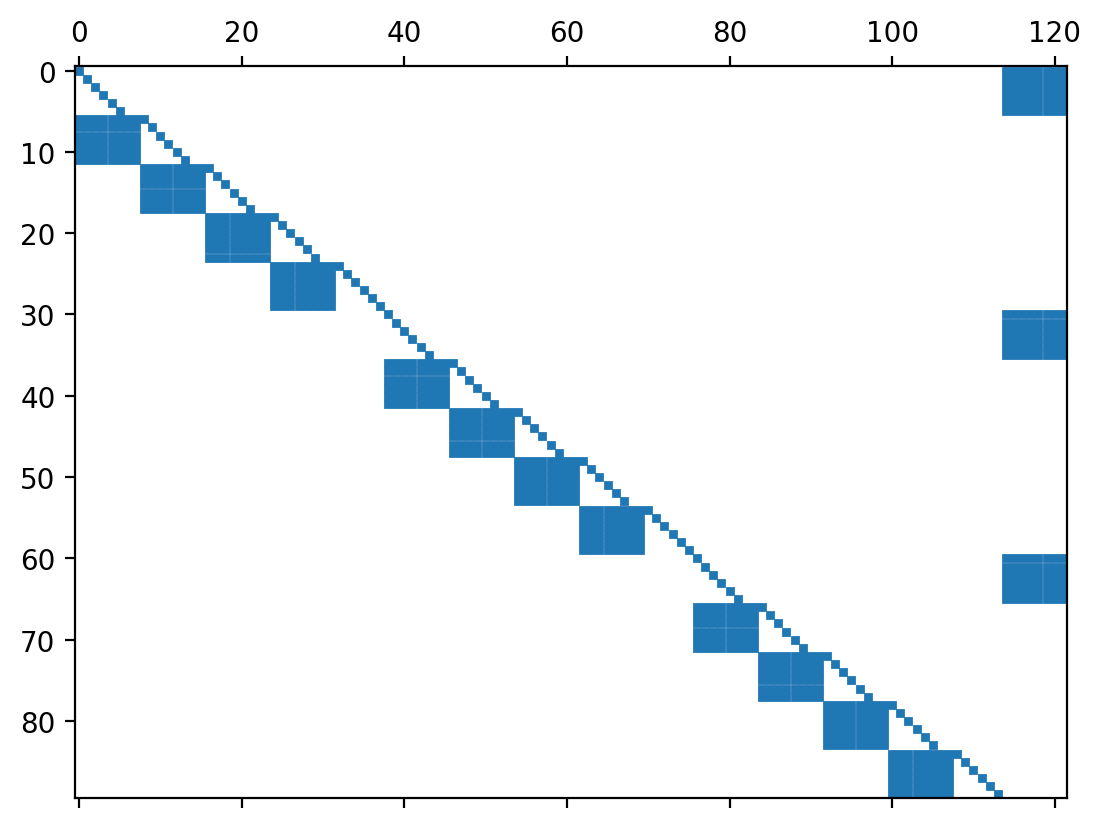

In [10]:
plt.spy(A, markersize=2)
plt.show()

As a last check, we can calculate the condensed KKT sparsity and verify that is has indeed a block-tri-diagonal-arrow structure. 

In [11]:
def setup_bounds():
    for s in range(Ns):
        offset = s * ((N - 1) * (nx + nu) + nx) - (nx + nu)
        for i in range(N):
            if i > 0:
                x_l[offset+i*(nx+nu)+nx:offset+i*(nx+nu)+nx+nu] = -systems[s].nu_max
                x_u[offset+i*(nx+nu)+nx:offset+i*(nx+nu)+nx+nu] = systems[s].nu_max
            x_l[offset+(i+1)*(nx+nu):offset+(i+1)*(nx+nu)+nx] = -systems[s].nx_max
            x_u[offset+(i+1)*(nx+nu):offset+(i+1)*(nx+nu)+nx] = systems[s].nx_max

setup_bounds()

The last remaining part are the state and input constraints which are direct bounds on the primal decision variable.

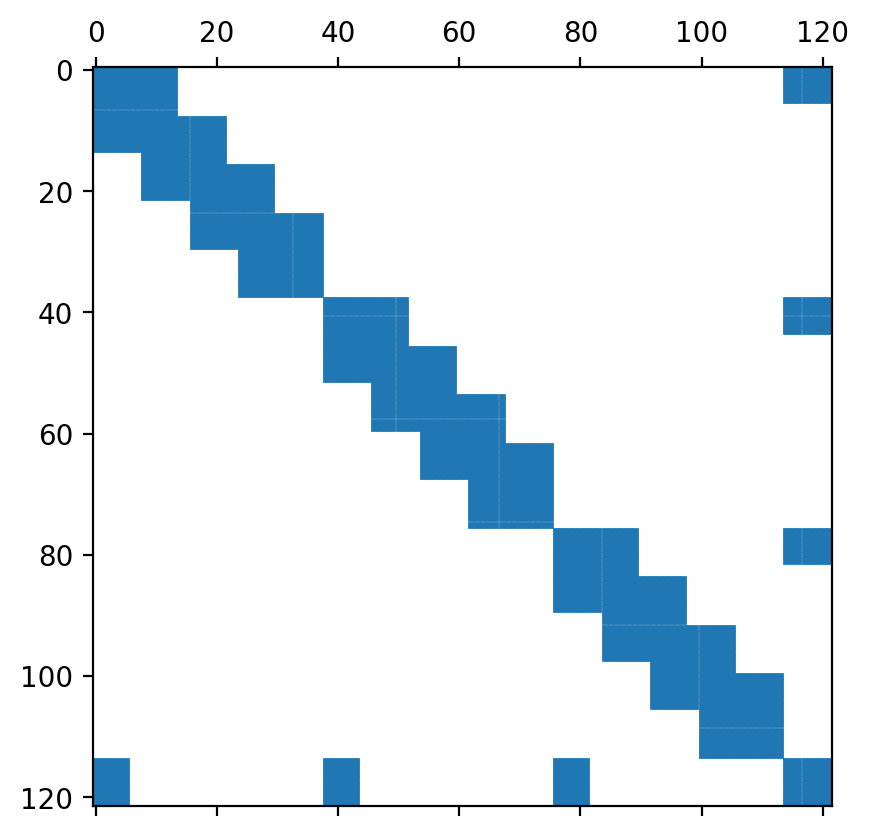

In [12]:
KKT_structure = P + A.T @ A
plt.spy(KKT_structure, markersize=1.75)
plt.show()

It's time to solve the problem using PIQP. In a first step we'll use the default sparse KKT backend.

In [13]:
sparse_solver = piqp.SparseSolver()
sparse_solver.settings.verbose = True
sparse_solver.settings.compute_timings = True

sparse_solver.setup(P=P, c=c, A=A, b=b, x_l=x_l, x_u=x_u)
status = sparse_solver.solve()

----------------------------------------------------------
                           PIQP                           
                    (c) Roland Schwan                     
   Ecole Polytechnique Federale de Lausanne (EPFL) 2025   
----------------------------------------------------------
sparse backend (sparse_ldlt)
variables n = 122, nzz(P upper triangular) = 375
equality constraints p = 90, nnz(A) = 1260
inequality constraints m = 0, nnz(G) = 0
inequality lower bounds n_h_l = 0
inequality upper bounds n_h_u = 0
variable lower bounds n_x_l = 122
variable upper bounds n_x_u = 122

iter  prim_obj       dual_obj       duality_gap   prim_res      dual_res      rho         delta       mu          p_step   d_step
  0    3.25459e+02   -1.09791e+06   1.09824e+06   1.93609e-03   6.63672e+02   1.000e-06   1.000e-04   1.177e+04   0.0000   0.0000
  1    7.50453e+02   -2.77013e+05   2.77764e+05   1.83182e-03   2.15106e+01   1.450e-07   1.450e-05   1.706e+03   0.8673   0.9900
  2    3.18009e+

So sunrises here. PIQP is able so solve this problem to very high accuracy, but we can solve the problem faster. Let's switch to the `sparse_multistage` KKT solver backend. Note that the interface doesn't change and PIQP does all the heavy lifting under the hood.

In [14]:
multistage_solver = piqp.SparseSolver()
multistage_solver.settings.verbose = True
multistage_solver.settings.compute_timings = True
multistage_solver.settings.kkt_solver = piqp.KKTSolver.sparse_multistage

multistage_solver.setup(P=P, c=c, A=A, b=b, x_l=x_l, x_u=x_u)
status = multistage_solver.solve()

----------------------------------------------------------
                           PIQP                           
                    (c) Roland Schwan                     
   Ecole Polytechnique Federale de Lausanne (EPFL) 2025   
----------------------------------------------------------
sparse backend (sparse_multistage)
variables n = 122, nzz(P upper triangular) = 375
equality constraints p = 90, nnz(A) = 1260
inequality constraints m = 0, nnz(G) = 0
inequality lower bounds n_h_l = 0
inequality upper bounds n_h_u = 0
variable lower bounds n_x_l = 122
variable upper bounds n_x_u = 122
block sizes: 8,6 8,6 8,6 14,0 8,6 8,6 8,6 14,0 8,6 8,6 8,6 14,0
arrow width: 8

iter  prim_obj       dual_obj       duality_gap   prim_res      dual_res      rho         delta       mu          p_step   d_step
  0    3.25459e+02   -1.09791e+06   1.09824e+06   1.93609e-03   6.63672e+02   1.000e-06   1.000e-04   1.177e+04   0.0000   0.0000
  1    7.50453e+02   -2.77013e+05   2.77764e+05   1.83182e-03

Looking at the debug information, we can see that we are now using the `sparse_multistage` KKT solver backend, and we also get information about the detected block sizes and the detected arrow width. We can visualize this using the sparsity pattern of the condensed KKT matrix.

![kkt structure](kkt_structure.svg)

In [15]:
sp_solve_time = sparse_solver.result.info.solve_time
ms_solve_time = multistage_solver.result.info.solve_time
speedup = sp_solve_time / ms_solve_time
print(f'Solve speedup: {speedup:0.3}x')

Solve speedup: 1.48x


For such a relatively small problem, the speedup is not particularly high with *only* 44% speedup. Let's rerun the previous cells with a bigger problem instance and see the speedup.

In [16]:
M = 15  # number of masses
N = 20  # MPC horizon
Ns = 25 # number of scenarios

setup_systems()
x0 = random_x0()
setup_problem()
setup_x0_u0()
setup_cost()
setup_dynamics()
setup_bounds()

In [17]:
sparse_solver = piqp.SparseSolver()
sparse_solver.settings.verbose = False
sparse_solver.settings.compute_timings = True
sparse_solver.setup(P=P, c=c, A=A, b=b, x_l=x_l, x_u=x_u)
status = sparse_solver.solve()

multistage_solver = piqp.SparseSolver()
multistage_solver.settings.verbose = False
multistage_solver.settings.compute_timings = True
multistage_solver.settings.kkt_solver = piqp.KKTSolver.sparse_multistage
multistage_solver.setup(P=P, c=c, A=A, b=b, x_l=x_l, x_u=x_u)
status = multistage_solver.solve()

sp_solve_time = sparse_solver.result.info.solve_time
ms_solve_time = multistage_solver.result.info.solve_time
speedup = sp_solve_time / ms_solve_time
print(f'Solve speedup: {speedup:0.3}x')

Solve speedup: 6.12x


Now we have considerably higher speedup. This is many due to more efficient use of vectorized instructions and cache locality.

In a last step, let's extract the solution and visualize it.

In [18]:
# extract solution

X = np.zeros((nx, N + 1, Ns))
U = np.zeros((nu, N, Ns))

x = multistage_solver.result.x

for s in range(Ns):
    X[:, 0, s] = x[-(nx+nu):-nu]
    U[:, 0, s] = x[-nu:]
    offset = s * ((N - 1) * (nx + nu) + nx) - (nx + nu)
    for i in range(1, N):
        X[:, i, s] = x[offset+i*(nx+nu):offset+i*(nx+nu)+nx]
        U[:, i, s] = x[offset+i*(nx+nu)+nx:offset+i*(nx+nu)+nx+nu]
    X[:, N, s] = x[offset+N*(nx+nu):offset+N*(nx+nu)+nx]

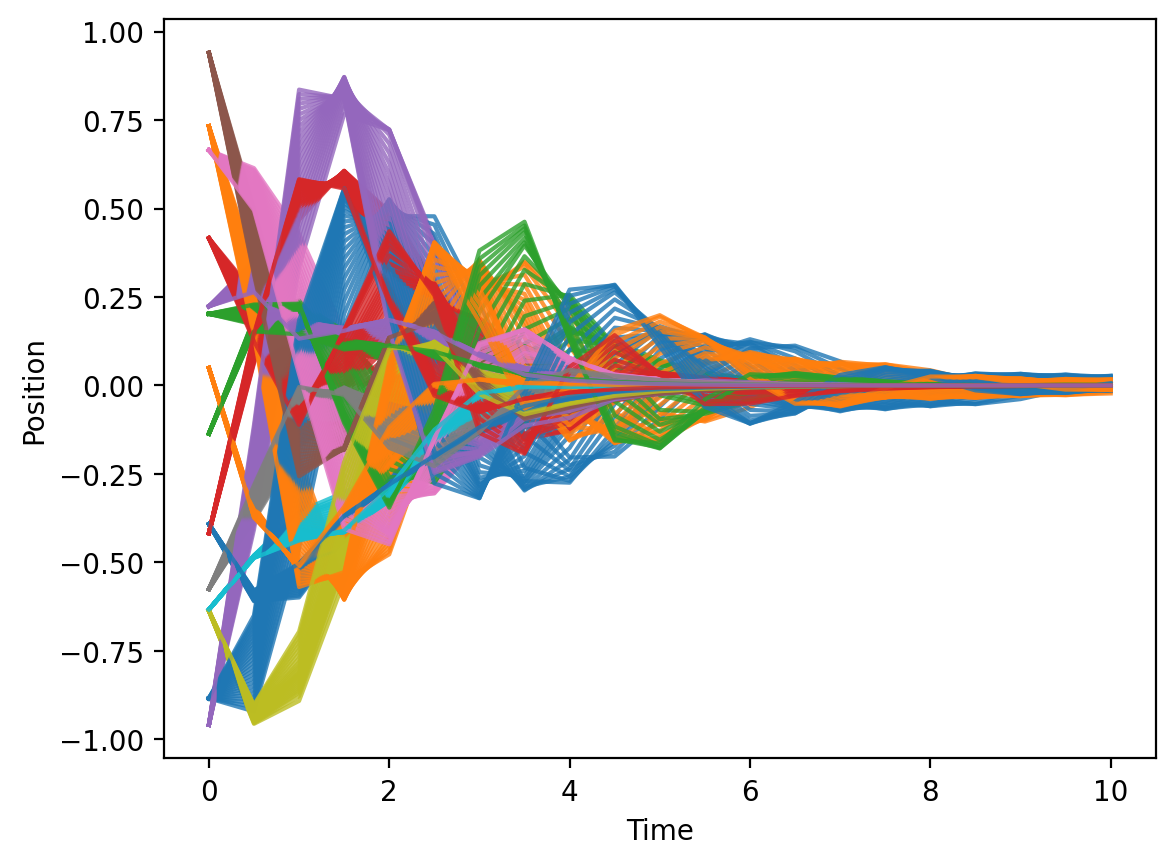

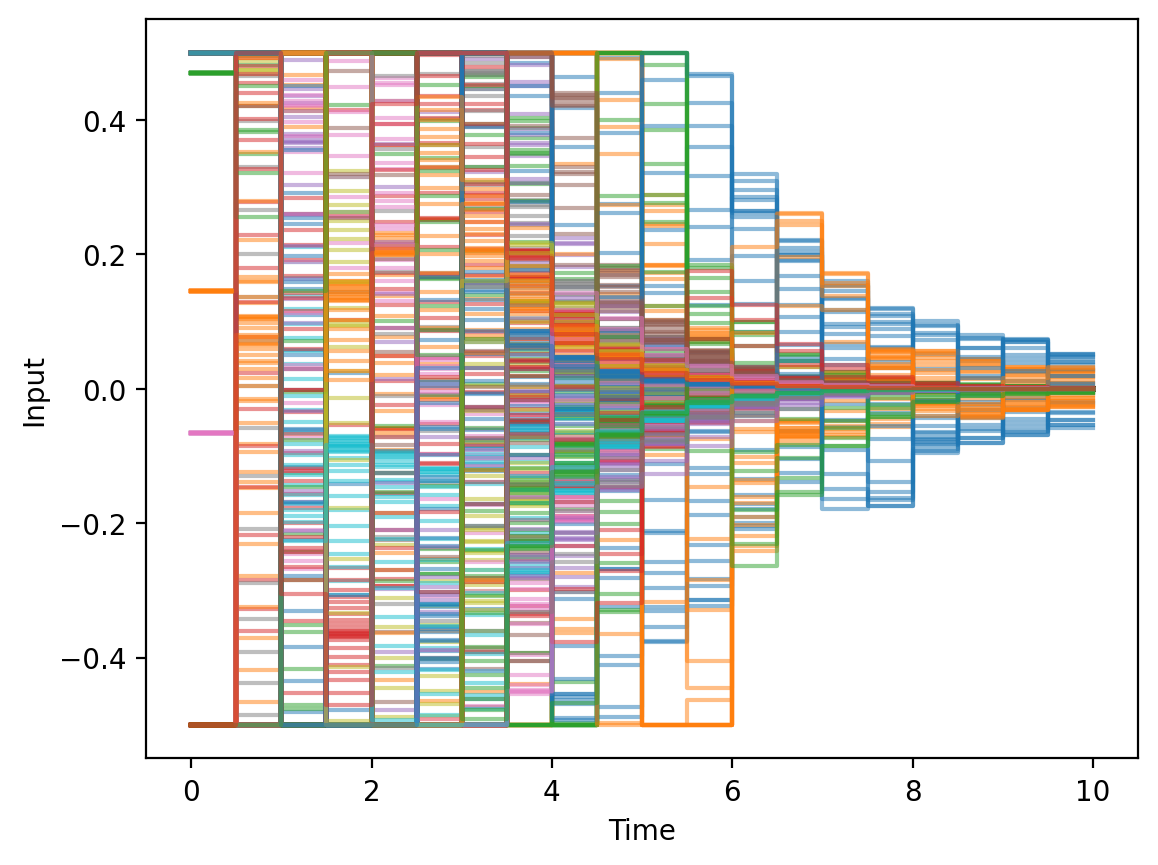

In [19]:
# plot solution

time = np.linspace(0, 0.5 * N, N + 1)

for s in range(Ns):
    plt.gca().set_prop_cycle(None)  # Reset the color cycle to the beginning
    plt.plot(time, X[:M, :, s].T, alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

for s in range(Ns):
    plt.gca().set_prop_cycle(None)  # Reset the color cycle to the beginning
    for i in range(U.shape[0]):
        plt.step(time, np.append(U[i, :, s], U[i, -1, s]), alpha=0.5, where='post')
plt.xlabel('Time')
plt.ylabel('Input')
plt.show()